In [13]:
from pathlib import Path

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import yaml
from common import (
    calculate_image_size,
    calculate_top_left_coordinates,
    generate_grid,
    plot_heatmap,
    rotate_90_cc,
    to_matrix,
)
from shapely import Polygon

with open("../plotting_config.yaml", "r") as fp:
    config = yaml.safe_load(fp)

ox.settings.use_cache = True
ox.settings.log_console = False

In [2]:
weeplace = pd.read_csv("../data/weeplace/weeplace_checkins.csv", engine="pyarrow")
weeplace = gpd.GeoDataFrame(
    weeplace,
    geometry=gpd.points_from_xy(weeplace.lon, weeplace.lat, crs=4326),
    crs=4326,
)
weeplace.head(3)

,userid,placeid,datetime,lat,lon,city,category,geometry
0,fred-wilson,tocqueville-new-york,2010-10-22 23:44:29,40.736300,-73.992200,New York,Food:American,POINT (-73.99220 40.73630)
1,fred-wilson,wesleyan-university-usdan-university-center-mi...,2010-10-23 17:00:24,41.556974,-72.657571,Middletown,College & Education:Student Center,POINT (-72.65757 41.55697)
2,fred-wilson,javapalooza-middletown,2010-10-23 20:30:45,41.558853,-72.648618,Middletown,Food:Coffee Shop,POINT (-72.64862 41.55885)


In [3]:
# Toronto
CRS = 7991
figures = "../figures/toronto"
output = "../output/toronto"
rx, ry = 4000, 4000
sx, sy = 100000 // rx, 100000 // ry
query = "(lat.between(43, 43.9) & lon.between(-80, -78.775))"

In [4]:
# # London
# CRS = 27700
# figures = "../figures/london"
# output = "../output/london"
# rx, ry = 500, 500
# sx, sy = 100000 // rx, 100000 // ry
# query = "(lat.between(51, 51.9) & lon.between(-0.9, 0.515))"

In [5]:
Path(figures).mkdir(parents=True, exist_ok=True)
Path(output).mkdir(parents=True, exist_ok=True)

(264172.79738995945, 4762165.079586866, 363851.7849083473, 4862160.927633976)

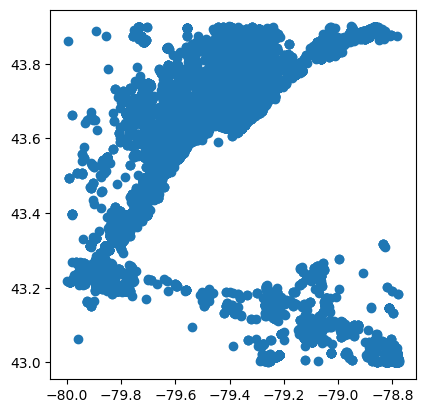

In [6]:
weeplace.query(query).plot()
data = weeplace.query(query).copy()
data_crs = weeplace.query(query).to_crs(CRS)
minx, miny, maxx, maxy = data_crs.unary_union.envelope.bounds
data_crs.unary_union.envelope.bounds

In [7]:
# London
tminx = np.floor(minx / rx) * rx
tmaxx = np.floor(maxx / rx) * rx
tminy = np.floor(miny / ry) * ry
tmaxy = np.floor(maxy / ry) * ry

# Toronto
if "toronto" in figures:
    tminx = np.floor(minx / rx) * rx
    tmaxx = np.ceil(maxx / rx) * rx
    tminy = np.floor(miny / ry) * ry
    tmaxy = np.floor(maxy / ry) * ry

print(tmaxx - tminx)
print(tmaxy - tminy)

100000.0
100000.0


In [8]:
area = Polygon([(tminx, tminy), (tmaxx, tminy), (tmaxx, tmaxy), (tminx, tmaxy)])
area_wgs84 = gpd.GeoDataFrame(geometry=[area], crs=CRS).to_crs(4326).geometry[0]

grid = generate_grid(tminx, tmaxx, tminy, tmaxy, stepx=rx, stepy=ry, crs=CRS)

In [9]:
data_with_grid = (
    data_crs.sjoin(grid)
    .groupby(["x", "y"])["userid"]
    .agg(["count", "nunique"])
    .reset_index()
)

In [10]:
enriched_grid = grid.merge(data_with_grid, on=["x", "y"], how="left").fillna(0)
enriched_grid["bin"] = enriched_grid["count"].apply(lambda x: 1 if x > 0 else 0)

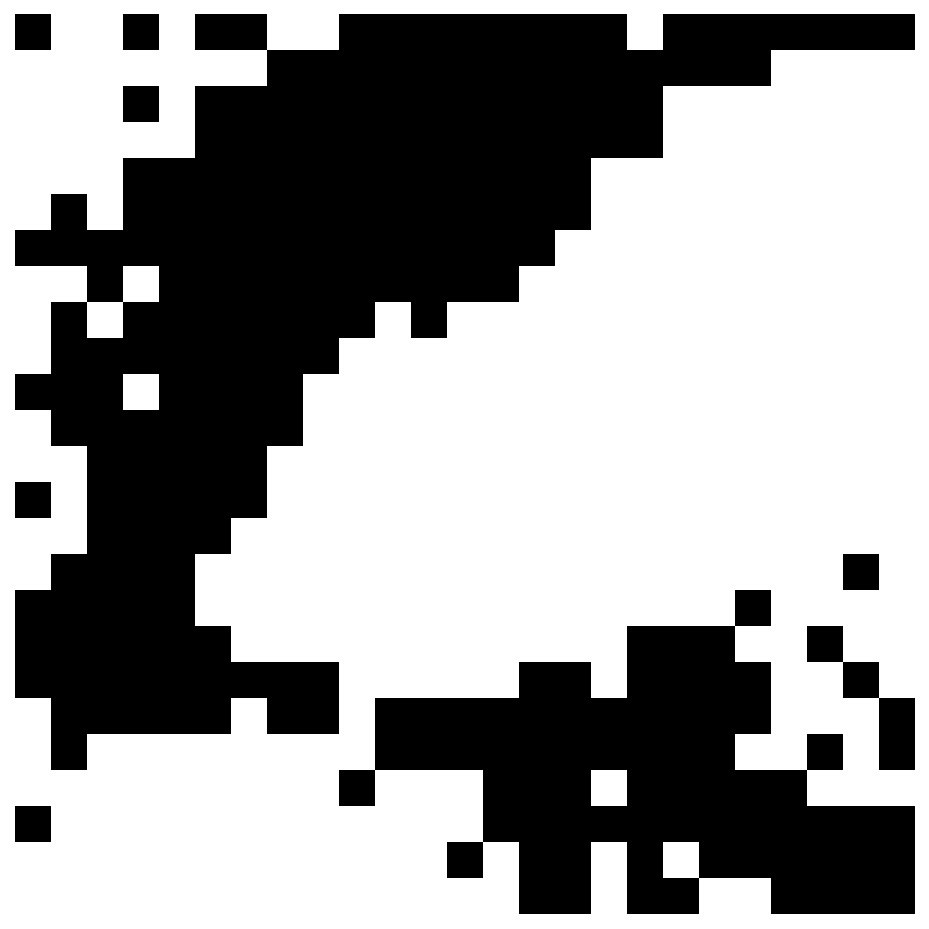

In [11]:
f_g = plt.figure(figsize=(6, 6), dpi=150)
a_g = f_g.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
enriched_grid.plot(column="bin", cmap="binary", ax=a_g)
a_g.margins(0)
a_g.axis("off")
a_g.set_facecolor("white")

f_g.savefig(
    f"{figures}/grid_{rx}_{ry}.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

In [12]:
enriched_grid.to_file(f"{output}/grid_{rx}_{ry}_enriched.geojson")

In [234]:
enriched_grid

,geometry,x,y,count,nunique,bin
0,"POLYGON ((264000.000 4760000.000, 268000.000 4...",0,0,0.0,0.0,0
1,"POLYGON ((264000.000 4764000.000, 268000.000 4...",0,1,0.0,0.0,0
2,"POLYGON ((264000.000 4768000.000, 268000.000 4...",0,2,1.0,1.0,1
3,"POLYGON ((264000.000 4772000.000, 268000.000 4...",0,3,0.0,0.0,0
4,"POLYGON ((264000.000 4776000.000, 268000.000 4...",0,4,0.0,0.0,0
...,...,...,...,...,...,...
620,"POLYGON ((360000.000 4840000.000, 364000.000 4...",24,20,0.0,0.0,0
621,"POLYGON ((360000.000 4844000.000, 364000.000 4...",24,21,0.0,0.0,0
622,"POLYGON ((360000.000 4848000.000, 364000.000 4...",24,22,0.0,0.0,0
623,"POLYGON ((360000.000 4852000.000, 364000.000 4...",24,23,0.0,0.0,0


In [235]:
enriched_grid["x"] += 1
enriched_grid["y"] += 1

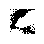

In [236]:
mx = rotate_90_cc(to_matrix(enriched_grid, shape=(sx, sy), value="bin"))

f_b, _ = plot_heatmap(mx, figsize=(sx, sy), dpi=1, cmap="binary")
f_b.savefig(
    f"{figures}/activity_binary_{rx}_{ry}.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)
f_b, _ = plot_heatmap(mx, figsize=(sx / 100, sy / 100), dpi=100, cmap="binary")
f_b.savefig(
    f"{figures}/activity_binary_{rx}_{ry}_dpi_fixed.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

In [237]:
large = area.buffer(100000).envelope
large_crs = gpd.GeoDataFrame(geometry=[large], crs=CRS).geometry[0]
large_wgs84 = gpd.GeoDataFrame(geometry=[large], crs=CRS).to_crs(4326).geometry[0]

In [238]:
try:
    landuse = pd.read_pickle(f"{output}/landuse_crs.pickle")
except FileNotFoundError:
    landuse = ox.features_from_polygon(
        large_wgs84, tags={"landuse": ["residential", "retail", "industrial"]}
    )
    landuse = landuse[landuse["geometry"].geom_type == "Polygon"].copy()
    landuse.to_crs(CRS, inplace=True)
    landuse.to_pickle(f"{output}/landuse_crs.pickle")

In [239]:
if not Path(f"{figures}/landuse.png").exists():
    f_lu = plt.figure(figsize=(6, 6), dpi=150)
    a_lu = f_lu.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
    gpd.clip(landuse, area).plot(ax=a_lu, color="black")
    a_lu.margins(0)
    a_lu.axis("off")
    a_lu.set_facecolor("white")

    f_lu.savefig(
        f"{figures}/landuse.png",
        facecolor="white",
        pad_inches=0,
        metadata=config["metadata"],
    )

In [240]:
W, H = calculate_image_size(large_crs.bounds, rx, ry)
print(W, H)

75.0 75.0


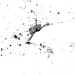

In [241]:
fig = plt.figure(figsize=(W, H), dpi=1)
ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
gpd.GeoDataFrame(geometry=[large_crs], crs=CRS).plot(
    color="white", aspect=None, ax=ax, zorder=1
)
landuse.plot(color="#000000", aspect=None, ax=ax, zorder=5)
ax.margins(0)
ax.axis("off")
ax.set_facecolor("white")
fig.patch.set_visible(False)

fig.savefig(
    f"{figures}/large_{rx}_{ry}.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

(25, 25)


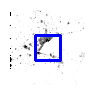

In [242]:
large_image = cv2.imread(f"{figures}/large_{rx}_{ry}.png")
template = cv2.imread(f"{figures}/activity_binary_{rx}_{ry}.png")

method = cv2.TM_CCOEFF_NORMED
result = cv2.matchTemplate(large_image, template, method)

min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

# Step 2: Get the size of the template. This is the same size as the match.
trows, tcols = template.shape[:2]

# If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
    top_left = min_loc
else:
    top_left = max_loc
bottom_right = (top_left[0] + trows, top_left[1] + tcols)
print(top_left)

# Step 3: Draw the rectangle on large_image
cv2.rectangle(large_image, top_left, bottom_right, (0, 0, 255), 2)

fig2 = plt.figure(figsize=(W / 100, H / 100), dpi=100)
ax2 = fig2.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
ax2.imshow(large_image)
ax2.axis("off")
ax2.margins(0)
fig2.patch.set_visible(False)
fig2.savefig(
    f"{figures}/location_{rx}_{ry}.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

In [243]:
startx, starty = calculate_top_left_coordinates(area, *top_left, rx, ry)
print(startx, starty)

with open(f"{output}/anchor_{rx}_{ry}.yaml", "w") as fp:
    yaml.dump(
        {
            "top_left": {"x": round(startx, 3), "y": round(starty, 3)},
            "area": {
                "bounds": {
                    "minx": area.bounds[0],
                    "maxx": area.bounds[2],
                    "miny": area.bounds[1],
                    "maxy": area.bounds[3],
                }
            },
        },
        fp,
    )

364000.0 4760000.0
